# 앙상블 학습과 랜덤 포레스트

- 앙상블 학습: 일련의 예측기로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있다. (큰 수의 법칙)  
- 랜덤 포레스트: 결정 트리의 앙상블  

다양한 분류기를 만드는 방법  
- 각기 다른 훈련 알고리즘 사용  
- 훈련 세트의 서브셋을 무작위로 구성  

## 7.1 투표 기반 분류기

직접 투표: 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측(다수결 방식)  

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# moons dataset
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc',svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.904


간접 투표: 모든 분류기가 클래스의 확률을 예측할 수 있다면, 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스로 예측하는 방식  

In [4]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)], voting="soft"
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## 7.1 배깅과 페이스팅

- 배깅: 훈련 세트에서 중복을 허용하여 샘플링하는 방식  
- 페이스팅: 중복을 허용하지 않고 샘플링하는 방식

수집 함수  
- 분류: 통계적 최빈값  
- 회귀: 평균  

개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소함  
(일반적으로 앙상블 적용시 하나의 예측기에 비해 편향은 비슷하지만 분산이 줄어듦)

### 7.2.1 사이킷런의 배깅과 페이스팅

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [10]:
# 앙상블
print(accuracy_score(y_test, y_pred))

0.92


In [9]:
# 단일 결정 트리
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [12]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np


def plot_decision_boundary(
    clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True
):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#7d7d58", "#4c4c7f", "#507d50"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

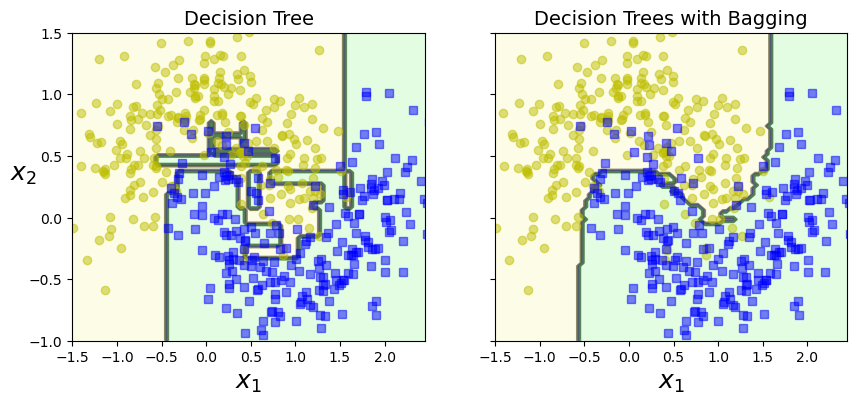

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

### 7.2.2 obb 평가

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [19]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.904

In [22]:
# 각 훈련 샘플에 대한 클래스 확률
bag_clf.oob_decision_function_[:10]

array([[0.35869565, 0.64130435],
       [0.31843575, 0.68156425],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06077348, 0.93922652],
       [0.33142857, 0.66857143],
       [0.02197802, 0.97802198],
       [0.98717949, 0.01282051],
       [0.97282609, 0.02717391]])

## 7.3 랜덤 패치와 랜덤 서브스페이스

랜덤 패치 방식: 훈련 특성과 샘플을 모두 샘플링하는 방식  
랜덤 서브스페이스 방식: 훈련 샘플을 모두 사용하고 특성은 샘플링하는 방식  

`BaggingClassifier`  
- 특성: `max_features`, `bootstrap_features`로 조절  
- 샘플: `max_samples`, `bootstrap`로 조절  

## 7.4 랜덤 포레스트

배깅 방법을 적용한 결정 트리 앙상블  

In [26]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [24]:
# BaggingClassifier 사용
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

### 7.4.1 엑스트라 트리

엑스트라 트리(익스트림 랜덤 트리)  
- 트리를 최대한 무작위하게 만들기 위해, 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 최상의 분할을 선택  
- 모든 노드에서 특성마다 최적의 임곗값을 찾는 것이 트리에서 가장 시간이 많이 소요되는 작업이므로, 일반적인 랜덤 포레스트보다 훨씬 빠름  

In [28]:
# RandomForestClassifier와 사용법은 동일함
from sklearn.ensemble import ExtraTreesClassifier

etr_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
etr_clf.fit(X_train, y_train)

y_pred_etr = etr_clf.predict(X_test)
accuracy_score(y_test, y_pred_etr)

0.92

### 7.4.2 특성 중요도

- 랜덤 포레스트는 특성의 상대적 중요도를 측정하기 쉬움  
- 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정 (가중치 평균)  

In [29]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name,score)

sepal length (cm) 0.09809212341063134
sepal width (cm) 0.0201670622235303
petal length (cm) 0.43736048664908006
petal width (cm) 0.4443803277167583


## 7.5 부스팅

- 약한 학습기를 여러 개 연결하여 강항 학습기를 만드는 앙상블 방법  
- 앞의 모델을 보완해나가면서 일련의 예측기를 학습 (앞선 모델의 오차를 학습)  

### 7.5.1 아다부스트

이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높여 학습하기 어려운 샘플(잘못 분류된 샘플)을 더 학습함

In [30]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200, 
    algorithm="SAMME.R", learning_rate=0.5
)
ada_clf.fit(X_train,y_train)

y_pred_ada = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred_ada)

/Users/yeseo/miniconda/envs/ame/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.896

### 7.5.2 그래디언트 부스팅

아다부스트처럼 샘플의 가중치를 수정하는 대신, 이전 예측기가 만든 **잔여 오차**에 새로운 예측기를 학습  

In [34]:
# 데이터 셋
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)

In [35]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [36]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [37]:
y3 = y - tree_reg1.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [39]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.60839441])

In [42]:
# GBRT ensemble
from sklearn.ensemble import GradientBoostingRegressor

# learning_rate 매개변수가 각 트리의 기여 정도를 조절 (작은 학습률로 훈련시키는 방법을 축소 규제 방법이라고 함)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

`staged_predict()` 메서드를 사용하여 간단하게 조기 종료(early stopping) 구현  

In [44]:
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train,y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=118)

`warm_start=True`로 설정하여 `fit()`호출 시 기존 트리를 유지하고 훈련을 추가로 할 수 있음  

In [46]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)
# gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, subsample=0.25)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1,120):
    gbrt.n_estimators_ = n_estimators
    gbrt.fit(X_train, y_train)

    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # 5번 내에 검증 오차가 향상되지 않으면 훈련 조기 종료

확률적 그래디언트 부스팅: `subsample` 매개변수를 사용하여 무작위로 샘플링한 훈련 샘플로 학습 (편향이 높아지는 대신 분산이 낮아지고, 훈련 속도를 높임)  

## 7.6 스태킹

스태킹(stacked generalization)  
- 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 **취합하는 모델을 훈련*8시킬 수는 없을까?  
- 각 예측기가 수행한 예측값들을 마지막 예측기(**블렌더** 또는 **메타 학습기**)가 받아 최종 예측을 만듦  
- 블렌더 학습에는 일반적으로 **홀드 아웃 세트** 사용  

홀드 아웃 세트(hold-out set)   
1. 훈련 세트를 두 개의 서브셋으로 나눔(첫 번째 서브셋은 첫 번째 레이어의 예측을 훈련시키기 위해 사용)  
2. 첫 번째 레이어의 예측기를 이용해 두 번째 (홀드 아웃) 세트에 대한 예측을 만듦, 예측기들이 훈련하는 동안 이 샘플들을 전혀 보지 못했기 때문에 이때 만들어진 예측은 완전히 새로운 것임  
3. 홀드 아웃 세트의 각 샘플에 대해 세 개의 예측값이 만들어짐  
4. 타깃값은 그대로 쓰고 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있음  
5. 블렌더가 새 훈련 세트로 훈련됨.  

훈련 세트를 여러 개의 서브셋으로 나누어 블랜더를 여러 개 훈련시키는 것도 가능함  

In [50]:
# http://github.com/viisar/brew 구현 시 참고

## 7.7 연습문제

1. 정확히 같은 훈련 데이터로 다섯 개의 다른 모델을 훈련시켜서 모두 95% 정확도를 얻었다면 이 모델들을 연결하여 더 좋은 결과를 얻을 수 있을까요? 가능하다면 어떻게 해야 할까요? 그렇지 않다면 왜일까요?

2. 직접 투표와 간접 투표 분류기 사이의 차이점은 무엇일까요?

3. 배깅 앙상블의 훈련을 여러 대의 서버에 분산시켜 속도를 높일 수 있을까요? 페이스팅 앙 상블, 부스팅 앙상블, 랜덤 포레스트, 스태킹 앙상블의 경우는 어떨까요?

4. oob 평가의 장점은 무엇인가요?

5. 무엇이 엑스트라 트리를 일반 랜덤 포레스트보다 더 무작위하게 만드나요? 추가적인 무작위성이 어떻게 도움이 될까요? 엑스트라 트리는 일반 랜덤 포레스트보다 느릴까요, 빠를까요?

6. 아다부스트 앙상블이 훈련 데이터에 과소적합되었다면 어떤 매개변수를 어떻게 바꾸어야 할까요?

7. 그래디언트 부스팅 앙상블이 훈련 데이터에 과대적합되었다면 학습률을 높여야 할까요, 낮춰야 할까요?

8. (3장에서 소개한) MINIST 데이터를 불러들여 훈련 세트, 검증 세트, 테스트 세트로 나눕니다 (예를 들면 훈련에 40,000개 샘플, 검증에 10,000개 샘플, 테스트에 10,000개 샘플). 그런 다음 랜덤 포레스트 분류기, 엑스트라 트리 분류기, SVM 같은 여러 종류의 분 류기를 훈련시킵니다. 그리고 검증 세트에서 개개의 분류기보다 더 높은 성능을 내도록 이들을 간접 또는 직접 투표 분류기를 사용하는 앙상블로 연결해보세요. 앙상블을 얻고 나면 테스트 세트로 확인해보세요. 개개의 분류기와 비교해서 성능이 얼마나 향상되나요?

9. 이전 연습문제의 각 분류기를 실행해서 검증 세트에서 예측을 만들고 그 결과로 새로운 훈련 세트를 만들어보세요. 각 훈련 샘플은 하나의 이미지에 대한 전체 분류기의 예측을 담은 벡터고 타깃은 이미지의 클래스입니다. 새로운 훈련 세트에 분류기 하나를 훈련시켜보세요. 방금 블렌더를 훈련시켰습니다. 그리고 이 분류기를 모아서 스태킹 앙상블을 구성했 습니다. 이제 테스트 세트에 앙상블을 평가해보세요. 테스트 세트의 각 이미지에 대해 모든 분류기로 예측을 만들고 앙상블의 예측 결과를 만들기 위해 블렌더에 그 예측을 주입합니다. 앞서 만든 투표 분류기와 비교하면 어떤가요?